In [1]:
from hdt_util import ArmadilloV1_feeder
from forecasters import ArmadilloV1

import numpy as np
import scipy
import datetime

import matplotlib.pyplot as plt

In [2]:
loader = ArmadilloV1_feeder('./request_cache')

data = loader.get_data(source='jhu-csse', 
                       signal='deaths', 
                       start_date=datetime.date(2020, 3, 1),
                       end_date=datetime.date(2020, 10, 31), 
                       level='county', 
                       count=True, 
                       cumulated=False,
                       mobility_level=1)

filtered_data = loader.area_filter(input=data, area=['06113'])

In [3]:
filtered_data.tail()

,geo_value,date,case_value,time,dayofweek,mobility_value
234,06113,2020-10-21,2.0,235,2,0.326461
235,06113,2020-10-22,0.0,236,3,0.325340
236,06113,2020-10-23,0.0,237,4,0.291457
237,06113,2020-10-24,0.0,238,5,0.286957
238,06113,2020-10-25,1.0,239,6,0.342345


## Fit on weekly data

In [4]:
weekly_data = loader.pooling(input=filtered_data, period=7, end_date=datetime.date(2020, 10, 25))
weekly_data.tail()

,geo_value,time,case_value,mobility_value
29,06113,29,1.0,0.300287
30,06113,30,1.0,0.310830
31,06113,31,0.0,0.322165
32,06113,32,0.0,0.321461
33,06113,33,3.0,0.316212


In [5]:
#34 entries, use the first 30 as training data
train = weekly_data.iloc[:30,]

In [6]:
model = ArmadilloV1()

In [7]:
DC = train['time'].values
DC = scipy.stats.gamma.pdf(DC*7, scale=model.args['gamma_scale'], a=model.args['gamma_shape'])
DC = DC/np.sum(DC) * model.args['death_rate']

In [8]:
args = {'M':train['mobility_value'].values,
        'DC':DC,
        'y_true':train['case_value'].values}
model.fit(args)

In [9]:
prediction = model.forecast(l=4)
prediction

array([0.        , 0.        , 0.03104218, 0.2411063 , 0.72266475,
       1.50281266, 2.19445486, 2.55802259, 2.66031258, 2.631393  ,
       2.5528069 , 2.46010011, 2.36584295, 2.27384438, 2.18507519,
       2.09968668, 2.01761525, 1.93874736, 1.86296142, 1.79013777,
       1.72016077, 1.65291919, 1.58830609, 1.52621874, 1.4665584 ,
       1.4092302 , 1.35414298, 1.30120914, 1.25034449, 1.20146816,
       1.15450241, 1.10937258, 1.06600688, 1.02433636])

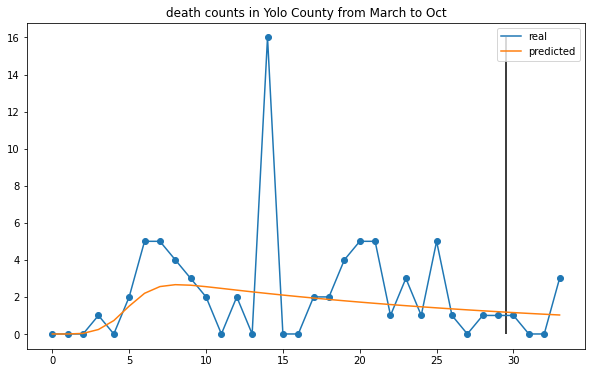

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_data['case_value'].values, label='real')
plt.scatter(range(34), weekly_data['case_value'].values)
plt.plot(prediction, label='predicted')
plt.title('death counts in Yolo County from March to Oct')
plt.vlines(x=29.5, ymin=0, ymax=16, colors='black')
plt.legend()
plt.show()

# Same data, every 3 days

In [11]:
pooled_data = loader.pooling(input=filtered_data, period=3, end_date=datetime.date(2020, 10, 25))
pooled_data.tail()

,geo_value,time,case_value,mobility_value
74,06113,74,0.0,0.336418
75,06113,75,0.0,0.320010
76,06113,76,0.0,0.314500
77,06113,77,2.0,0.323971
78,06113,78,1.0,0.306920


In [12]:
train = pooled_data.iloc[:70,]

model = ArmadilloV1()

DC = train['time'].values
DC = scipy.stats.gamma.pdf(DC*3, scale=model.args['gamma_scale'], a=model.args['gamma_shape'])
DC = DC/np.sum(DC) * model.args['death_rate']

args = {'M':train['mobility_value'].values,
        'DC':DC,
        'y_true':train['case_value'].values}
model.fit(args)

In [13]:
prediction = model.forecast(l=9)
prediction

array([0.        , 0.        , 0.01639112, 0.11323095, 0.25334563,
       0.37906013, 0.48523039, 0.57812135, 0.64745857, 0.68564411,
       0.69706531, 0.69500923, 0.68580978, 0.67139449, 0.64644714,
       0.60970263, 0.57104963, 0.53400895, 0.50109405, 0.47393203,
       0.45169451, 0.43369354, 0.41856319, 0.40474037, 0.38781312,
       0.36661599, 0.34544042, 0.32621308, 0.31003969, 0.29440629,
       0.28070696, 0.27009913, 0.26207014, 0.25656299, 0.25307589,
       0.25225612, 0.25299682, 0.25479285, 0.25743863, 0.26056765,
       0.2649371 , 0.26977947, 0.2754001 , 0.2816535 , 0.28836297,
       0.29375786, 0.29863907, 0.30370906, 0.30920516, 0.31613914,
       0.32330935, 0.33130431, 0.33931886, 0.34876024, 0.36021017,
       0.37238376, 0.38498256, 0.39694292, 0.41055419, 0.42410597,
       0.43571951, 0.44611429, 0.45758064, 0.47478516, 0.50041093,
       0.53401753, 0.56839226, 0.599458  , 0.62976607, 0.66183313,
       0.70054259, 0.74463435, 0.79828555, 0.85638747, 0.91304

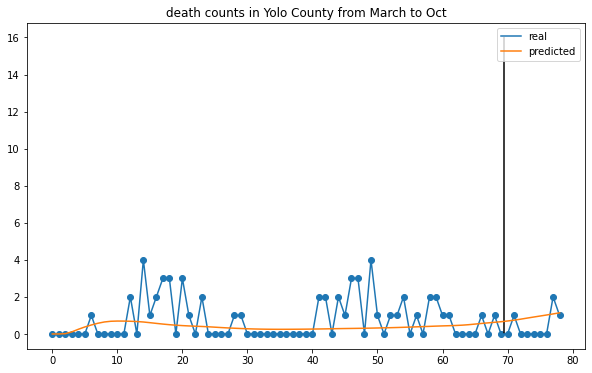

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(pooled_data['case_value'].values, label='real')
plt.scatter(range(79), pooled_data['case_value'].values)
plt.plot(prediction, label='predicted')
plt.title('death counts in Yolo County from March to Oct')
plt.vlines(x=69.5, ymin=0, ymax=16, colors='black')
plt.legend()
plt.show()